In [1]:
import numpy as np

from epymorph.geography.us_census import StateScope
from epymorph.log.messaging import sim_messaging
from epymorph.simulator.basic.basic_simulator import BasicSimulator
from epymorph.time import TimeFrame

# Construct a multistrata RUME

import matplotlib.pyplot as plt
from sympy import Max

from epymorph.kit import *
from epymorph.adrio import acs5


class MyRume(MultiStrataRUMEBuilder):
    strata = [
        GPM(
            name="age_00-19",
            ipm=ipm.SIRS(),
            mm=mm.No(),
            init=init.NoInfection(),
        ),
        GPM(
            name="age_20-59",
            ipm=ipm.SIRS(),
            mm=mm.No(),
            init=init.SingleLocation(location=0, seed_size=100),
        ),
        GPM(
            name="age_60-79",
            ipm=ipm.SIRS(),
            mm=mm.No(),
            init=init.NoInfection(),
        ),
    ]

    meta_requirements = [
        AttributeDef("beta_12", float, Shapes.TxN),
        AttributeDef("beta_13", float, Shapes.TxN),
        AttributeDef("beta_21", float, Shapes.TxN),
        AttributeDef("beta_23", float, Shapes.TxN),
        AttributeDef("beta_31", float, Shapes.TxN),
        AttributeDef("beta_32", float, Shapes.TxN),
    ]

    def meta_edges(self, symbols: MultiStrataModelSymbols) -> list[TransitionDef]:
        # extract compartment symbols by strata
        S_1, I_1, R_1 = symbols.strata_compartments("age_00-19")
        S_2, I_2, R_2 = symbols.strata_compartments("age_20-59")
        S_3, I_3, R_3 = symbols.strata_compartments("age_60-79")

        # extract compartment totals by strata
        N_1 = Max(1, S_1 + I_1 + R_1)
        N_2 = Max(1, S_2 + I_2 + R_2)
        N_3 = Max(1, S_3 + I_3 + R_3)

        # extract meta attributes
        beta_12, beta_13, beta_21, beta_23, beta_31, beta_32 = (
            symbols.all_meta_requirements
        )

        return [
            edge(S_1, I_1, rate=S_1 * beta_12 * I_2 / N_2),  # 2 infects 1
            edge(S_1, I_1, rate=S_1 * beta_13 * I_3 / N_3),  # 3 infects 1
            edge(S_2, I_2, rate=S_2 * beta_21 * I_1 / N_1),  # 1 infects 2
            edge(S_2, I_2, rate=S_2 * beta_23 * I_3 / N_3),  # 3 infects 2
            edge(S_3, I_3, rate=S_3 * beta_31 * I_1 / N_1),  # 1 infects 3
            edge(S_3, I_3, rate=S_3 * beta_32 * I_2 / N_2),  # 2 infects 3
        ]


rume = MyRume().build(
    scope=StateScope.in_states(["AZ"], year=2020),
    time_frame=TimeFrame.of("2020-01-01", 180),
    params={
        # IPM params
        "gpm:age_00-19::ipm::beta": 0.05,
        "gpm:age_20-59::ipm::beta": 0.20,
        "gpm:age_60-79::ipm::beta": 0.35,
        "*::ipm::gamma": 1 / 10,
        "*::ipm::xi": 1 / 90,
        "meta::ipm::beta_12": 0.05,
        "meta::ipm::beta_13": 0.05,
        "meta::ipm::beta_21": 0.20,
        "meta::ipm::beta_23": 0.20,
        "meta::ipm::beta_31": 0.35,
        "meta::ipm::beta_32": 0.35,
        # ADRIOs for population by age
        "*::*::population_by_age_table": acs5.PopulationByAgeTable(),
        "gpm:age_00-19::*::population": acs5.PopulationByAge(0, 19),
        "gpm:age_20-59::*::population": acs5.PopulationByAge(20, 59),
        "gpm:age_60-79::*::population": acs5.PopulationByAge(60, 79),
    },
)

rng = np.random.default_rng(seed=0)
sim = BasicSimulator(rume)
with sim_messaging():
    out = sim.run(rng_factory=(lambda: rng))

Loading gpm:age_00-19::init::population_by_age_table (epymorph.adrio.acs5.PopulationByAgeTable):
  |####################| 100%  (0.955s)
Running simulation (BasicSimulator):
• 2020-01-01 to 2020-06-28 (180 days)
• 1 geo nodes
  |####################| 100%                    
Runtime: 0.055s


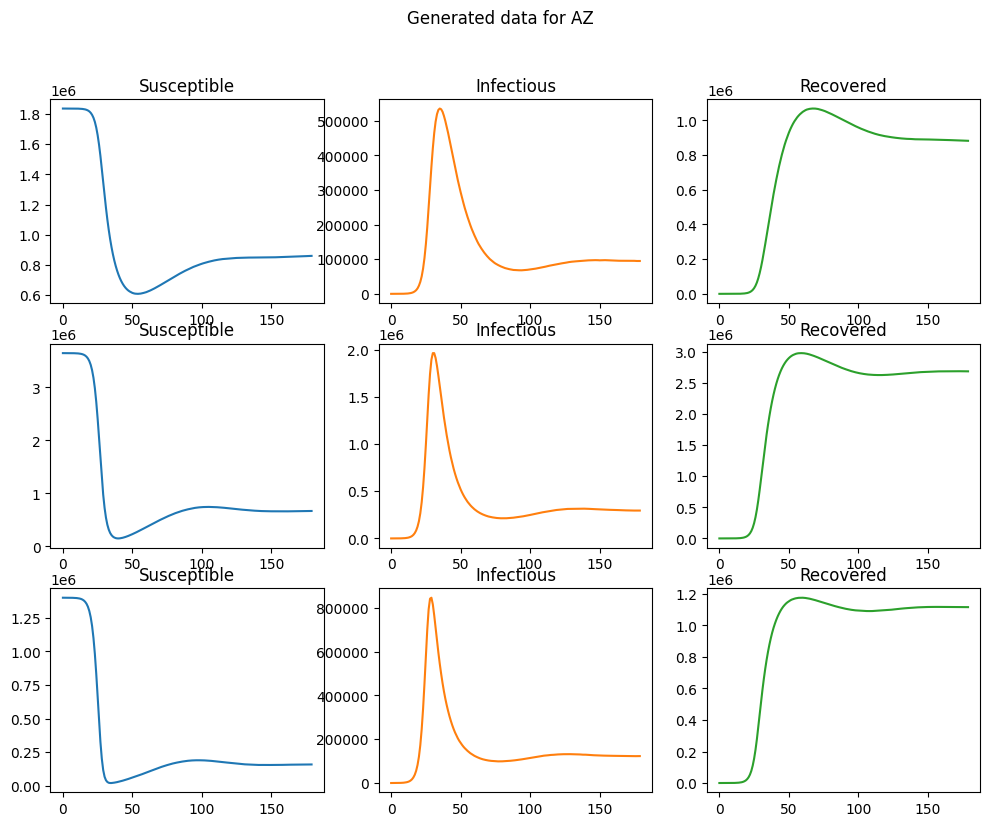

In [2]:
node = 0
alpha = 1
ticks = np.arange(rume.num_ticks)
names = [
    "Susceptible",
    "Infectious",
    "Recovered",
    "Susceptible",
    "Infectious",
    "Recovered",
    "Susceptible",
    "Infectious",
    "Recovered",
]
colors = [
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:blue",
    "tab:orange",
    "tab:green",
]
fig, axs = plt.subplots(3, 3)
fig.set_figwidth(12)
fig.set_figheight(9)
axs = np.ravel(axs)
for q_idx in range(len(axs)):
    ax = axs[q_idx]
    tx = ticks
    qt = out.compartments[:, node, q_idx]
    ax.plot(tx, out.compartments[:, node, q_idx].T, color=colors[q_idx])
    ax.set_title(names[q_idx])

fig.suptitle(f"Generated data for {rume.scope.labels[node]}")
plt.show()

In [3]:
# rng = np.random.default_rng(seed=0)
# sim = BasicSimulator(rume)
# out = sim.run(rng_factory=(lambda: rng))

from epymorph.forecasting.multi_simulator import MultiSimulator

num_realizations = 100
# pop = 6_000_000
initial_values = np.zeros(shape=(num_realizations, 1, 9), dtype=np.int64)

for i_realization in range(num_realizations):
    num_infectious = i_realization * 20
    initial_values[i_realization, ...] = np.array(
        [
            [
                2e6 - num_infectious,
                num_infectious,
                0,
                4e6 - num_infectious,
                num_infectious,
                0,
                1e6 - num_infectious,
                num_infectious,
                0,
            ]
        ]
    )

sim = MultiSimulator()
out = sim.run(
    rume=rume,
    num_realizations=num_realizations,
    param_values=None,
    initial_values=initial_values,
    rng_factory=(lambda: rng),
)

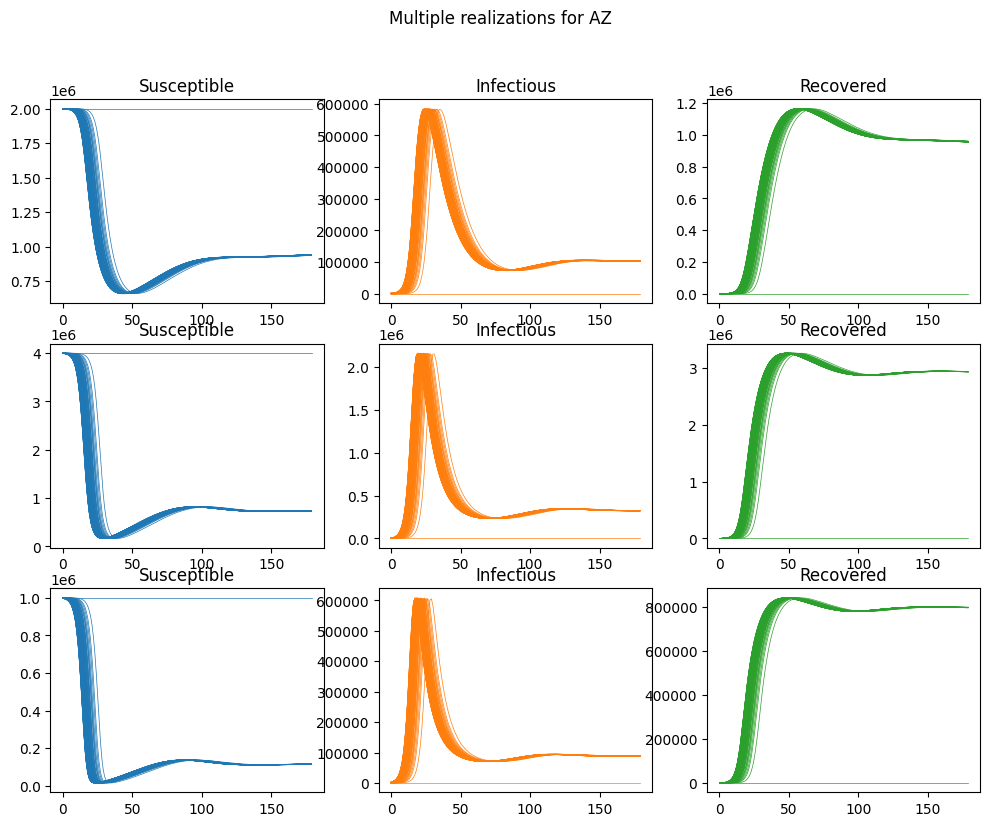

In [4]:
out.visit_compartments.shape

import matplotlib.pyplot as plt

node = 0
alpha = 1
ticks = np.arange(rume.num_ticks)
names = [
    "Susceptible",
    "Infectious",
    "Recovered",
    "Susceptible",
    "Infectious",
    "Recovered",
    "Susceptible",
    "Infectious",
    "Recovered",
]
colors = [
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:blue",
    "tab:orange",
    "tab:green",
]
fig, axs = plt.subplots(3, 3)
fig.set_figwidth(12)
fig.set_figheight(9)
axs = np.ravel(axs)
for q_idx in range(len(axs)):
    ax = axs[q_idx]
    tx = ticks
    ax.plot(
        tx,
        out.visit_compartments[:, :, node, q_idx].T,
        color=colors[q_idx],
        linewidth=0.5,
    )
    ax.set_title(names[q_idx])

fig.suptitle(f"Multiple realizations for {rume.scope.labels[node]}")
plt.show()